<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/deom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained PyTorch RetinaNet Object Detection For Inference on Test Images.


### **Setting up Colab :**

In [ ]:
# What GPU do we have ?
!nvidia-smi

Mon Oct 26 20:18:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [ ]:
# Clone the RetinaNet Repo
!git clone https://github.com/benihime91/pytorch_retinanet.git
# install dependencies
!pip install pytorch-lightning omegaconf --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet
!echo "Installed all depedencies ! "

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 2051 (delta 7), reused 10 (delta 5), pack-reused 2032
Receiving objects: 100% (2051/2051), 78.14 MiB | 31.69 MiB/s, done.
Resolving deltas: 100% (1357/1357), done.
     |████████████████████████████████| 542kB 10.9MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 276kB 49.0MB/s 
     |████████████████████████████████| 829kB 53.6MB/s 
     |████████████████████████████████| 952kB 8.4MB/s 
Installed all depedencies ! 


In [ ]:
#Update sys path to enclude the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[BCCD Dataset](https://public.roboflow.com/object-detection/bccd)** from RoboFlow. There are 364 images across three classes.


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!curl -L "[YOUR LINK]" > roboflow.zip; unzip -qq roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1338      0 --:--:-- --:--:-- --:--:--  1338
100 6087k  100 6087k    0     0  6149k      0 --:--:-- --:--:-- --:--:-- 48.3M


In [ ]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/train/"
VALID_ANNOT_PATH = "/content/valid/"
TEST_ANNOT_PATH  = "/content/test/"

In [ ]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np

from utils.pascal import convert_annotations_to_df

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [ ]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")


def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

### **CSV Files are as follows :**

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/train/BloodImage_00147_jpg.rf.4ff5270c8f9af1231edc4d857bf03008.jpg,416,416,Platelets,130,216,155,255,1
1,/content/train/BloodImage_00147_jpg.rf.4ff5270c8f9af1231edc4d857bf03008.jpg,416,416,WBC,220,36,334,179,3
2,/content/train/BloodImage_00210_jpg.rf.e717500ee4f9e9f2e64b6c54acaa4f92.jpg,416,416,RBC,195,58,275,146,2
3,/content/train/BloodImage_00210_jpg.rf.e717500ee4f9e9f2e64b6c54acaa4f92.jpg,416,416,RBC,303,74,383,162,2
4,/content/train/BloodImage_00210_jpg.rf.e717500ee4f9e9f2e64b6c54acaa4f92.jpg,416,416,RBC,298,126,378,214,2


In [ ]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/valid/BloodImage_00252_jpg.rf.6f42aa6e17ac140440e01c87c8017722.jpg,416,416,RBC,115,42,181,127,2
1,/content/valid/BloodImage_00252_jpg.rf.6f42aa6e17ac140440e01c87c8017722.jpg,416,416,RBC,42,308,108,393,2
2,/content/valid/BloodImage_00252_jpg.rf.6f42aa6e17ac140440e01c87c8017722.jpg,416,416,RBC,367,342,415,415,2
3,/content/valid/BloodImage_00252_jpg.rf.6f42aa6e17ac140440e01c87c8017722.jpg,416,416,RBC,307,273,378,367,2
4,/content/valid/BloodImage_00252_jpg.rf.6f42aa6e17ac140440e01c87c8017722.jpg,416,416,RBC,101,329,181,415,2


In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/test/BloodImage_00386_jpg.rf.1de8e2e0e94f942d7a1523852d7fb146.jpg,416,416,RBC,1,264,69,367,2
1,/content/test/BloodImage_00386_jpg.rf.1de8e2e0e94f942d7a1523852d7fb146.jpg,416,416,RBC,128,62,193,141,2
2,/content/test/BloodImage_00386_jpg.rf.1de8e2e0e94f942d7a1523852d7fb146.jpg,416,416,RBC,187,305,256,407,2
3,/content/test/BloodImage_00386_jpg.rf.1de8e2e0e94f942d7a1523852d7fb146.jpg,416,416,RBC,304,204,385,309,2
4,/content/test/BloodImage_00386_jpg.rf.1de8e2e0e94f942d7a1523852d7fb146.jpg,416,416,RBC,288,338,353,415,2


In [ ]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df = pd.read_csv(TEST_CSV)

# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [ ]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'Platelets', 'RBC', 'WBC']

##**Plot images with Bounding boxes over them**:

In [ ]:
from utils import visualize_boxes_and_labels_on_image_array as viz_bbs
import matplotlib.pyplot as plt


def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index

    Params
    ------
        dataframe : a pandas dataframe object
        index (int) : a integer corresponding to a index in the pandas dataframe

    Returns
    -------
        fname (str) : path to the selected image.
        bbbs (list) : a list containing the bounding box annotations for the `fname`.
        cls (list) : a list containing the integer class labels for the box annotations.  
    """
    assert index <= len(dataframe), f"Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs  = dataframe.loc[dataframe.filename == fname]
    bbs   = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls   = locs["labels"].values
    return fname, bbs, cls

def load_image_from_data(dataframe, index):
    """
    Loads in a image from the given dataframe at given index
    Returns a PIL image object contraining all the bounding boxes over
    the image
    """
    image, boxes, clas = grab_bbs_(dataframe, index)
    #load and normalize the image
    image = Image.open(image)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=None, classes=clas, label_map=LABEL_MAP)
    return image

### **Image from Train Data:**

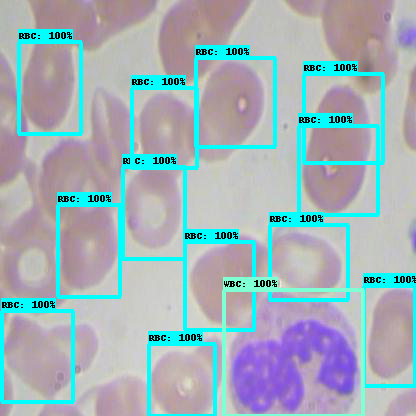

In [ ]:
image = load_image_from_data(train_df, index=10)
image

### **Image from Validation data:**

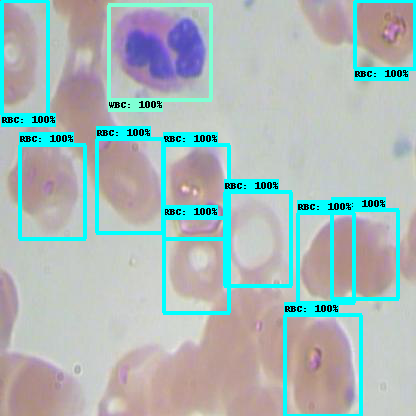

In [ ]:
image = load_image_from_data(valid_df, index=10)
image

###**Image from Test Data:**

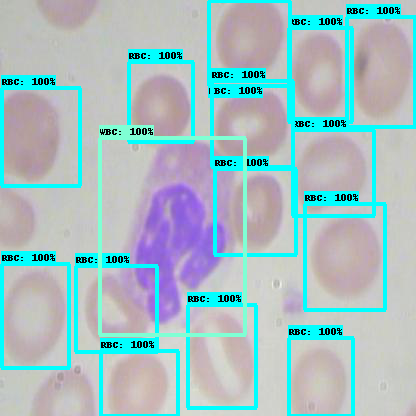

In [ ]:
image = load_image_from_data(test_df, index=5)
image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :

The configuration file is present in `/content/pytorch_retinanet/hparams.yaml`.


In [ ]:
from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
hparams.dataset.kind        = "csv"
hparams.dataset.trn_paths   = TRAIN_CSV #path to the train csv file
hparams.dataset.valid_paths = VALID_CSV #path to the valid csv file
hparams.dataset.test_paths  = TEST_CSV  #path to the test  csv file
#batch size
hparams.dataloader.train_bs = 1       #train batch size
hparams.dataloader.valid_bs = 28      #valid batch size
hparams.dataloader.test_bs  = 28      #test batch size
#Number of classes in the dataset (excluding the '__background__' class)
hparams.model.num_classes   = len(LABEL_MAP) - 1
hparams.model.backbone_kind = "resnet34" # resnet backbone for the RetinaNet model
hparams.model.min_size      = 800 #min size of the smallese size of the image after resize
hparams.model.max_size      = 800 #maximum size longest size of the image after resize
hparams.model.pretrained    = True #load in imagenet-backbone weights

#optimizer
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params": {"lr": 0.005, "momentum": 0.9, "weight_decay" : 0.01,},
    }
#scheduler
hparams.scheduler = {
    "class_name" : "torch.optim.lr_scheduler.StepLR",
    "params"     : {"step_size": 10, "gamma":0.1},
    "interval"   : "epoch",
    "frequency"  : 1,
    "monitor"    : False
}

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet34
  num_classes: 3
  freeze_bn: true
  min_size: 800
  max_size: 800
  pretrained: true
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 1
  valid_bs: 28
  test_bs: 28
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.005
    momentum: 0.9
    weight_decay: 0.01
scheduler:
  class_name: torch.optim.lr_scheduler.StepLR
  params:
    step_size: 10
    gamma: 0.1
  interval: epoch
  frequency: 1
  monitor: false



#**Instantiate Lightning-Module and Lightning-Trainer**

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import *
from pytorch_lightning.callbacks import *

from model import RetinaNetModel

# seed so that results are reproducible
pl.seed_everything(123)

123

## **Load in the Lighning-Trainer :**

In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

#Logger
#check: https://pytorch-lightning.readthedocs.io/en/latest/loggers.html,for all supported loggers
#we will Tensorboard
LOGGER = TensorBoardLogger("/content/tb_logs", name='retina_Lightning')

#Learning-rate Logger to log the learning-rate to the logger
LR_LOGGER = LearningRateMonitor(logging_interval="step")

#Model Checkpoint Callback, this callback will save checkpoints 
#each time our val loss decreases
fname =f"/content/checkpoints/"
os.makedirs(fname, exist_ok=True)
CHECKPOINT_CALLBACK = ModelCheckpoint(fname, mode="min", monitor="val_loss", save_top_k=3,)

#callback for early-stopping
EARLY_STOPPING_CALLBACK = EarlyStopping(mode="min", monitor="val_loss", patience=10, verbose=True)

#instantiate LightningTrainer
trainer = Trainer(
    precision=16, 
    max_epochs=30,
    gpus=1, 
    logger=[LOGGER],
    checkpoint_callback=CHECKPOINT_CALLBACK,
    callbacks=[LR_LOGGER, EARLY_STOPPING_CALLBACK],
    weights_summary='full',
    terminate_on_nan=True, 
    benchmark=True,
    );

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


##**Load in the Lighning-Module using the hparams file modified above & Start Train :**

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(hparams=hparams)

In [ ]:
trainer.fit(litModel)


    | Name                                                       | Type                     | Params
----------------------------------------------------------------------------------------------------------
0   | net                                                        | Retinanet                | 29 M  
1   | net.transform                                              | GeneralizedRCNNTransform | 0     
2   | net.backbone                                               | BackBone                 | 21 M  
3   | net.backbone.backbone                                      | ResNetBackbone           | 21 M  
4   | net.backbone.backbone.conv1                                | Conv2d                   | 9 K   
5   | net.backbone.backbone.bn1                                  | BatchNorm2d              | 128   
6   | net.backbone.backbone.relu                                 | ReLU                     | 0     
7   | net.backbone.backbone.maxpool                              | MaxPool2d        

1

In [ ]:
#Tensorboard logs
%load_ext tensorboard
%tensorboard --logdir "/content/tb_logs"

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
# Evaluations results on the test/ validation dataset(if test dataset is not given)
# using COCO API
trainer.test(litModel)

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.664
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

[{'AP': 0.3207755238927081}]

# **Export the model weights** :

In [ ]:
import torch
PATH = f"/content/trained_weights.pth"
torch.save(litModel.net.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
import logging
logger = logging.getLogger("lightning")

In [ ]:
from retinanet import Retinanet

#load saved model state dict
state_dict = torch.load(PATH)
#model arguments same as the arguments used to train the model
model_args = hparams.model
#load pytorch model without the lightning-module
#using args and state dict
MODEL      = Retinanet(**model_args, logger=logger)
MODEL.load_state_dict(state_dict)
MODEL.eval()
MODEL.to("cuda:0");

BACKBONE     : resnet34
INPUT_PARAMS : MAX_SIZE=800, MIN_SIZE=800
NUM_CLASSES  : 3


# **Run Inference on Test Images with Custom PyTorch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.

    Params
    ------
        image_path (str) : Path to the input Image
        threshold (float): Score threshold to filter predictions

    Returns
    -------
        A Dictionary contatining the predictions from generated from the model on 
        the given image. 
        Keys of the dictionary: 
          - "boxes" : bounding-box co-ordinates
          - "labels": class labels for the bounding box co-ordinates.
          - "scores": scores for the bounding box co-ordinates.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True)
        ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS  = MODEL.predict([TENSOR_IMAGE])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Params
    ------
        image_path `(str)` : Path to the input Image
        threshold `(float)`: Score threshold to filter predictions
    
    Returns
    -------
        boxes  `(np.array)`: filtered absolute bounding box co-ordinates.
        labels `(np.array)`: class labels for the bounding box co-ordinates.
        scores `(np.array)`: scores for the bounding box co-ordinates.
    """
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask   = scores > threshold
    boxes  = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

def draw_on_image(image_path, boxes, scores, classes, label_map=LABEL_MAP):
    """
    Draw bounding box over the image at image path, with the scores and classes
    Returns a PIL image object.
    
    Params
    ------ 
        image_path `(str)`   : Path to the input Image
        boxes `(List[N,4])`  : absolute bouding box co-ordiates in the form `[xmin,ymin,xmax,ymax]`.
        scores `(List[N])`   : List containing the scores for each of the bounding box.
        classes `(`List[N])` : List containing the class_labels for each of the bounding box.
        label_map `(List)`   : List of the labels

    Returns
    -------
        A PIL Image object
    """
    image = Image.open(image_path)
    image = np.array(image) / 255.
    image = viz_bbs(image, boxes, scores=scores, classes=classes, label_map=LABEL_MAP)
    return image

In [ ]:
idx = 10

#Path to the image
image_path = test_df.filename[idx]
#generate predictions for the image
boxes, labels, scores = detect(image_path, threshold=0.55)

pred_image = draw_on_image(image_path, boxes, scores, labels)

real_image = load_image_from_data(test_df, index=idx)

(-0.5, 415.5, 415.5, -0.5)

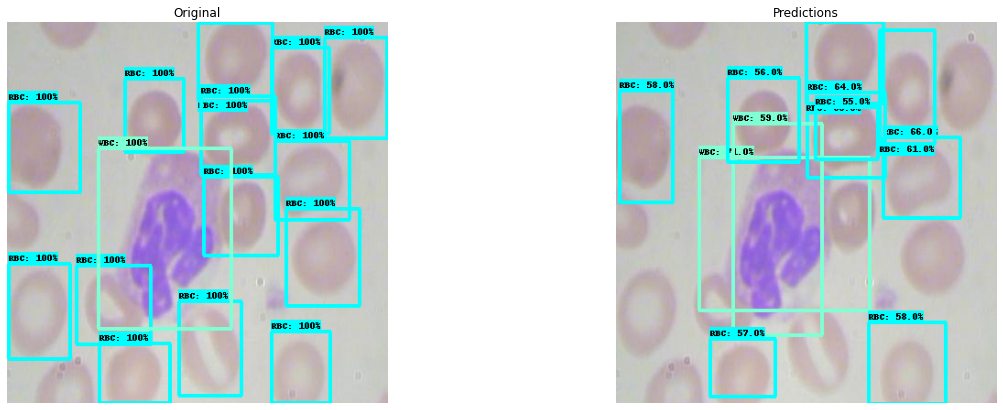

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

ax1.imshow(real_image)
ax1.set_title("Original")
ax1.axis("off")

ax2.imshow(pred_image)
ax2.set_title("Predictions")
ax2.axis("off")